# Feature importance plot

Creates figures representing the feature importance of the FTC, nFTC and general random forest experiments.

## Data loading

Loads the `.txt` files outputted by the experiment notebooks.

In [29]:
import python_proj.utils.exp_utils as exp_utils

base_path = exp_utils.BASE_PATH
file_name = "dataset_transformed"

experiments = ["rf_ftc", "rf_nftc", "rf_full"]

figure_base_path = f"{base_path}/figures/modelling/{file_name}/"

data = {}
for experiment in experiments:
    data_file = f"{figure_base_path}/{experiment}/feature_importance.txt"
    print(f'Loading from "{data_file}".')
    with open(data_file, "r", encoding="utf-8") as input_file:
        data[experiment] = input_file.read()

Loading from "/workspaces/msc_thesis/data//figures/modelling/dataset_transformed//rf_ftc/feature_importance.txt".
Loading from "/workspaces/msc_thesis/data//figures/modelling/dataset_transformed//rf_nftc/feature_importance.txt".
Loading from "/workspaces/msc_thesis/data//figures/modelling/dataset_transformed//rf_full/feature_importance.txt".


## Name mappings

Translates experimental names to human readable ones.

In [30]:
# Feature mapping
name_mapping = {
    "ln(1 + ControlPullRequestLifeTimeInMinutes)": "PR lifetime",
    "ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)": "Integrator exp.",
    "IntraProjectSubmitterPullRequestSuccessRate": "Intra. PR merge rate",
    "ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)": "Intra. PRs",
    "ln(1 + WeightedFirstOrderInDegreeCentrality)": "SO in-degree",
    "ControlIntegratedBySameUser": "PR is self-integrated",
    "ln(1 + WeightedFirstOrderOutDegreeCentrality)": "SO out-degree",
    "ln(1 + ControlNumberOfCommitsInPullRequest)": "PR commit count",
    "EcosystemExperienceSubmitterPullRequestSuccessRate": "Eco. PR merge rate",
    "ControlPullRequestHasComments": "PR has comments",
    "ln(1 + IntraProjectSubmitterPullRequestCommentCount)": "Intra. PR comments",
    "ln(1 + IntraProjectSubmitterIssueCommentCount)": "Intra. Issue Comments",
    "ln(1 + SubmitterToIntegratorLinkIntensity)": "Sub-to-int link",
    "ln(1 + EcosystemExperienceSubmitterIssueCommentCount)": "Eco. issue comments",
    "ln(1 + NonDependencyEcosystemExperienceSubmitterIssueCommentCount)": "Non-dep. issue comments",
    "SubmitterIsFirstTimeContributor": "First-time contr.",
    "ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)": "Eco. PRs",
    "ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)": "Eco. PR comments",
    "ln(1 + NonDependencyEcosystemExperienceSubmitterPullRequestCommentCount)": "Non-dep. PR comments",
    "ControlHasHashTagInDescription": "PR contains '#'",
    "ln(1 + NonDependencyEcosystemExperienceSubmitterIssueSubmissionCount)": "Non-dep. issues",
    "ln(1 + IntraProjectSubmitterIssueSubmissionCount)": "Intra. issues",
    "ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount)": "Eco. issues",
    "ln(1 + NonDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)": "Non-dep. PRs",
    "ln(1 + IntegratorToSubmitterLinkIntensity)": "Int-to-sub link",
    "ControlPullRequestHasCommentByExternalUser": "PR has com. ext. contr.",
    "NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate": "Non-dep PR merge rate",
    "ln(1 + DependencyEcosystemExperienceSubmitterPullRequestCommentCount)": "Downstr. PR comments",
    "ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)": "Downstr. PRs",
    "ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount)": "Downstr. issue comments",
    "ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueCommentCount)": "Upstr. issue comments",
    "DependencyEcosystemExperienceSubmitterPullRequestSuccessRate": "Downstr. PR merge rate",
    "ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestCommentCount)": "Upstr. PR comments",
    "ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)": "Upstr. PRs",
    "InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate": "Upstr. PR merge rate",
    "ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount)": "Downstr. issues",
    "ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount)": "Upstr. issues",
}

## Data parsing

In [31]:
from python_proj.utils.util import SafeDict

# parses the entries into separate dicts.
importances = SafeDict(default_value=dict)

for label, scores in data.items():
    for entry in scores.split("\n"):
        elements = entry.split(":")
        field = elements[0].strip()
        renamed_field = name_mapping[field]
        score = float(elements[1].strip())
        importances[label][renamed_field] = score

full_importances = importances["rf_full"]
ftc_importances = importances["rf_ftc"]
non_ftc_importances = importances["rf_nftc"]

## Figure creation code

In [32]:
from python_proj.utils.util import safe_save_fig
from typing import Any
import matplotlib.pyplot as plt


def create_figure(max_entries: int):
    # Creates dot plot.
    sorted_full_importances = {
        k: v for k, v in sorted(full_importances.items(), key=lambda item: -item[1])
    }
    sorted_full_importances = {
        k: v
        for i, (k, v) in enumerate(sorted_full_importances.items())
        if i < max_entries
    }
    sorted_ftc_importances = [
        ftc_importances[k] if k in non_ftc_importances else 0
        for k in sorted_full_importances.keys()
    ]
    sorted_non_ftc_importances = [
        non_ftc_importances[k] if k in non_ftc_importances else 0
        for k in sorted_full_importances.keys()
    ]
    sorted_full_importances_keys = sorted_full_importances.keys()
    sorted_full_importances = sorted_full_importances.values()

    def inverse(series: list[Any]) -> list[Any]:
        new_list = []
        series = list(series)
        length = len(series)
        for i in range(length - 1, -1, -1):
            new_list.append(series[i])
        return new_list

    sorted_full_importances = inverse(sorted_full_importances)
    sorted_ftc_importances = inverse(sorted_ftc_importances)
    sorted_non_ftc_importances = inverse(sorted_non_ftc_importances)
    sorted_full_importances_keys = inverse(sorted_full_importances_keys)

    # Increased width to provide more space for the left side
    height = 1.75 / 10 * max_entries + 1.25
    plt.figure(figsize=(5.35, height))

    # Plot each data series
    plt.plot(
        sorted_full_importances,
        sorted_full_importances_keys,
        "o",
        fillstyle="none",
        markersize=6,
        label="Full",
    )
    plt.plot(
        sorted_ftc_importances,
        sorted_full_importances_keys,
        "s",
        fillstyle="none",
        markersize=6,
        label="FTC",
    )
    plt.plot(
        sorted_non_ftc_importances,
        sorted_full_importances_keys,
        "D",
        fillstyle="none",
        markersize=6,
        label="Non-FTC",
    )

    # Add labels and title
    plt.xlabel("Mean Decrease in Gini")
    plt.ylabel("Predictors")
    plt.subplots_adjust(left=0.45)

    # Add a legend
    plt.legend()

    # Display the plot
    plt.tight_layout()
    # plt.show()

    output_path = f"./data/figures/importance_figure_{max_entries}.png"
    print(f"{output_path=}")
    safe_save_fig(output_path)

    # plt.show()

## Figure creation

output_path='./data/figures/importance_figure_10.png'


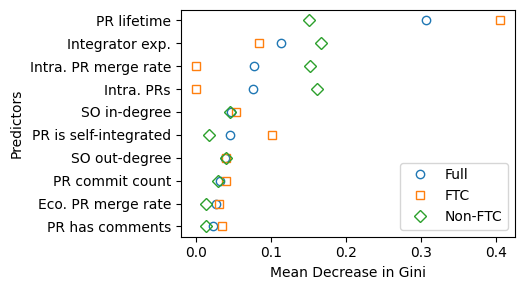

In [33]:
create_figure(10)

output_path='./data/figures/importance_figure_37.png'


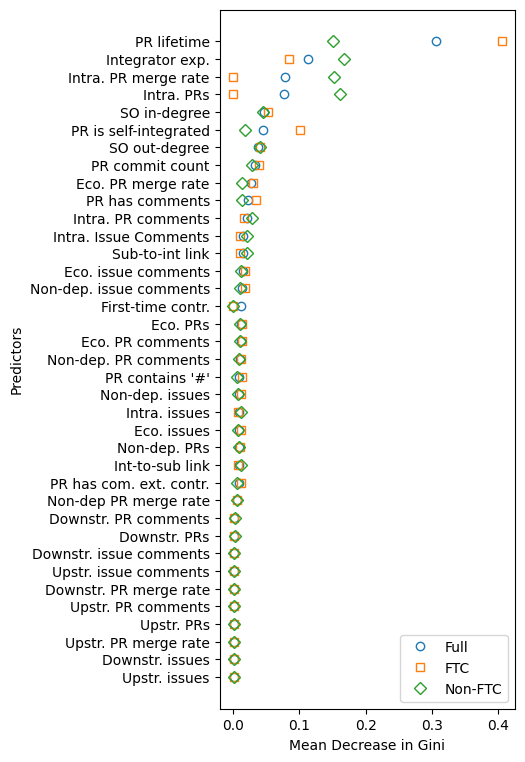

In [34]:
create_figure(len(name_mapping))